In [3]:
import pandas as pd
import lxml
import xml.etree.ElementTree as ET
from lxml import etree

In [4]:
def fill_celltype(df):
    """modifies dataframe in place"""
    remove_last = False
    celltype = df["CellType"].tolist()
    for ii, cc in enumerate(celltype[1:]):
        if cc == '':
    #         print(ii, cc, celltype[ii], sep=' -- ')
            if celltype[ii].lower() != 'diagnosis':
                celltype[ii+1] = celltype[ii]
#     if celltype[-1] == '':
#         celltype = celltype[:-1]
    df["CellType"] = celltype

In [8]:
def parse_pptx_table(fn_slide):
    tree = etree.parse(fn_slide)

    cells = []
    rows = tree.xpath('//*[name()="a:tr"]')
#     print(len(rows))
    for rn, row in enumerate(rows):
        cols = row.xpath('./*[name()="a:tc"]')
        for cn, col in enumerate(cols):
            tnodes = col.xpath('.//*[name()="a:t"]')
            if len(tnodes)>0:
                text = tnodes[0].text
            else:
                text = ''
    #         print(rn, cn, text)
            cells.append((rn, cn, text))

    df = pd.DataFrame.from_records(cells).set_index([0,1]).unstack()
    df.columns = df.iloc[0].tolist()
    df.drop(0, inplace=True)

    columns = df.columns.tolist()
    columns[0] = "CellType"
    columns[1] = "Criteria"
    df.columns = columns
    df = df[df["Criteria"] != '']
    fill_celltype(df)
    df.loc[df["CellType"] == "Diagnosis", "Comments"] = df.loc[df["CellType"] == "Diagnosis", "Criteria"]
    df.loc[df["CellType"] == "Diagnosis", "Criteria"] = "Diagnosis"
    
    # Fix the 'matrix' row:
    matrix_mask = (df["CellType"] == "Capillaries")& (df["Criteria"].map(len)==1)
    df.loc[matrix_mask, "Criteria"]  = "Matrix"
    df.set_index(["CellType", "Criteria"], inplace=True)
    return df

In [9]:
fn_slide = "ppt/slides/slide{}.xml".format(slidenumber)
df = parse_pptx_table(fn_slide)

In [126]:
# df["Y/N"] = df["Y/N"].map(lambda x: x.lower() == 'y')

In [130]:
# df["Criteria"].map(len)
# df["Y/N"]

In [11]:
dfbinary = []
dfcomments = []
for slidenumber in range(2, 123, 2):
    fn_slide = "ppt/slides/slide{}.xml".format(slidenumber)
    df = parse_pptx_table(fn_slide)
    dfbinary.append(df["Y/N"])
    dfcomments.append(df["Comments"])

In [12]:
dfcomments = pd.concat([ds.to_frame() for ds in dfcomments], axis=1)
dfcomments.columns = pd.np.arange(2,123,2)

In [13]:
dfbinary = pd.concat([ds.to_frame() for ds in dfbinary], axis=1).drop("Diagnosis")
dfbinary.columns = pd.np.arange(2,123,2)

/Users/jennifer/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [155]:
# dfbinary[2]

In [172]:
# dfcomments.loc[("Diagnosis", "Diagnosis")].value_counts()

In [171]:
# all_binary_values = []
# for cc in pd.np.arange(2,123,2):
#     all_binary_values.append(dfbinary[cc].map(lambda x:x.upper()).T.unique().tolist())

In [14]:
# all_binary_values
def remap_values(x):
    if x.upper() == 'Y':
        return True
    elif x.upper() == 'N':
        return False
    else:
        return pd.np.nan

In [15]:
dffinal = dfbinary.applymap(remap_values).T

In [16]:
dffinal[("Diagnosis", "Diagnosis")] = dfcomments.loc[("Diagnosis", "Diagnosis")]

In [17]:
cols = dffinal.columns.map(lambda x: '-'.join(x)).tolist()
cols[-1] = "Diagnosis"
dffinal.columns = cols

In [18]:
dffinal.index = pd.np.arange(len(dffinal))

In [19]:
dffinal.mean(axis=0)

Podocytes-Hypertrophy        0.721311
Podocytes-Hyperplasia        0.466667
Podocytes-Droplets           0.360656
Podocytes-Multinucleation    0.098361
Podocytes-Bridging           0.163934
Podocytes-Loss               0.049180
Capillaries-Retraction       0.360656
Capillaries-Cell loss        0.229508
Capillaries-Matrix           0.737705
Capillaries-Hypercellular    0.442623
Capillaries-Adhesion         0.409836
Other-Mesangium              0.131148
Other-Bowman’s capsule       0.237288
Other-Location of lesion     0.350000
dtype: float64

In [191]:
# dffinal.to_csv("")

,Podocytes-Hypertrophy,Podocytes-Hyperplasia,Podocytes-Droplets,Podocytes-Multinucleation,Podocytes-Bridging,Podocytes-Loss,Capillaries-Retraction,Capillaries-Cell loss,Capillaries-Matrix,Capillaries-Hypercellular,Capillaries-Adhesion,Other-Mesangium,Other-Bowman’s capsule,Other-Location of lesion,Diagnosis
0,True,False,True,False,False,False,False,False,True,True,False,False,False,False,CELL
1,True,False,False,False,True,False,False,False,True,False,False,False,False,NaN,NOS
2,False,False,False,False,False,False,False,False,False,False,True,False,False,True,TIP
3,False,False,True,False,False,False,False,False,True,True,False,True,False,True,Cell
4,False,False,True,False,False,False,False,False,True,True,True,False,False,True,Cell
5,True,True,False,False,False,False,False,False,False,True,True,False,False,True,TIP
6,True,True,True,False,False,False,False,False,True,True,True,False,True,True,Nos
7,True,False,False,False,False,False,True,False,True,False,False,False,False,False,NOS
8,True,True,False,False,False,False,True,False,True,False,False,True,False,False,COLL
9,True,True,False,False,False,False,True,False,False,False,True,False,False,False,COLL


In [61]:
import os
import os.path
import shutil
# labels and sorts images, can be more generalized in the future 
folder_path = "ppt/media"

#images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

#for image in images:
folder_name_pos = "Podocytes-Hyperplasia-pos"
folder_name_neg = "Podocytes-Hyperplasia-neg"
new_path_pos = os.path.join(folder_path, folder_name_pos)
new_path_neg = os.path.join(folder_path, folder_name_neg)
os.makedirs(new_path_pos)
os.makedirs(new_path_neg)




    
for i in range (0, len(dffinal)): 
       
    if dffinal.get_value(i,"Podocytes-Hyperplasia")== True:
        image = "image" + str(i+1) +".jpeg"
        old_path = os.path.join(folder_path, image)
        new_image_path_pos = os.path.join(new_path_pos, image)
        shutil.copy(old_path, new_image_path_pos)
        #shutil.move(folder_path, new_image_path_pos)
    else:
        image = "image" + str(i+1) +".jpeg"
        old_path = os.path.join(folder_path, image)
        new_image_path_neg = os.path.join(new_path_neg, image)
        shutil.copy(old_path, new_image_path_neg)
       

/Users/jennifer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [62]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np

from keras.models import Sequential
from keras import layers
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.layers import Input
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.preprocessing import image

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

/Users/jennifer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [71]:
train_path = "ppt/Podocytes_Hyperplasia/Train"
valid_path = "ppt/Podocytes_Hyperplasia/Validation"
test_path = "ppt/Podocytes_Hyperplasia/Test"

In [72]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['Positive', 'Negative'], batch_size=4)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['Positive', 'Negative'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['Positive', 'Negative'], batch_size=4)

Found 41 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [73]:
#plots images with labels within jupyter notebook

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [74]:
imgs, labels = next(train_batches)

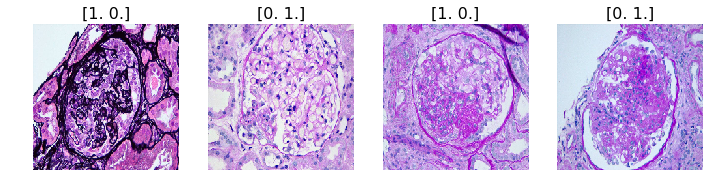

In [75]:
plots(imgs, titles=labels)

In [76]:
#build and train CNN

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    Flatten(),
    Dense(2, activation='softmax')
])

In [77]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
model.fit_generator(train_batches, steps_per_epoch=10,
                   validation_data=valid_batches, validation_steps=4, epochs=20, verbose=2)

Epoch 1/20
 - 2s - loss: 7.1878 - acc: 0.5541 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 2/20
 - 2s - loss: 8.4056 - acc: 0.4785 - val_loss: 7.0517 - val_acc: 0.5625
Epoch 3/20
 - 2s - loss: 7.9996 - acc: 0.5037 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/20
 - 2s - loss: 5.6829 - acc: 0.6474 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/20
 - 2s - loss: 6.4472 - acc: 0.6000 - val_loss: 7.0517 - val_acc: 0.5625
Epoch 6/20
 - 2s - loss: 8.5244 - acc: 0.4711 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 7/20
 - 2s - loss: 5.2770 - acc: 0.6726 - val_loss: 9.0664 - val_acc: 0.4375
Epoch 8/20
 - 2s - loss: 8.8115 - acc: 0.4533 - val_loss: 9.0664 - val_acc: 0.4375
Epoch 9/20
 - 2s - loss: 6.4214 - acc: 0.6016 - val_loss: 9.0664 - val_acc: 0.4375
Epoch 10/20
 - 2s - loss: 7.2531 - acc: 0.5500 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 11/20
 - 2s - loss: 7.5937 - acc: 0.5289 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 12/20
 - 2s - loss: 7.1878 - acc: 0.5541 - val_loss: 7.0517 - val_acc: 0.5625


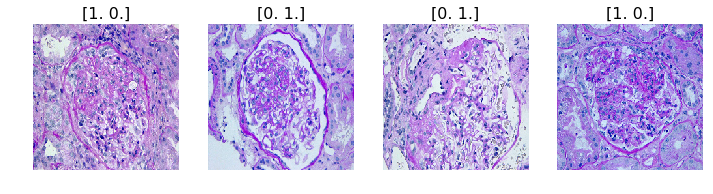

In [81]:
#predict

test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [82]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 0., 1.], dtype=float32)

In [83]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [84]:
predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [86]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [87]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[2 0]
 [2 0]]


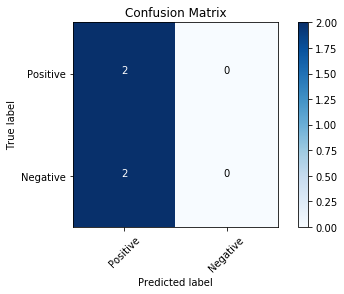

In [88]:
cm_plot_labels = ['Positive', 'Negative']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [90]:
#build fine-tuned VGG16 model
import keras 
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 402s 1us/step


In [91]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [92]:
type(vgg16_model)

keras.engine.training.Model

In [93]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [94]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [95]:
model.layers.pop()

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [98]:
for layer in model.layers:
    layer.trainable = False

In [99]:
model.add(Dense(2, activation='softmax'))

In [100]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [101]:
model.compile(Adam(lr=.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [102]:
model.fit_generator(train_batches, steps_per_epoch=10,
                   validation_data=valid_batches, validation_steps=4, epochs=10)

Epoch 1/10
10/10 [==============================] - 27s 3s/step - loss: 0.6916 - acc: 0.5467 - val_loss: 0.6916 - val_acc: 0.6250
Epoch 2/10
10/10 [==============================] - 27s 3s/step - loss: 0.6947 - acc: 0.5250 - val_loss: 0.6910 - val_acc: 0.6875
Epoch 3/10
10/10 [==============================] - 25s 2s/step - loss: 0.6949 - acc: 0.5588 - val_loss: 0.6965 - val_acc: 0.5625
Epoch 4/10
10/10 [==============================] - 25s 3s/step - loss: 0.6926 - acc: 0.4785 - val_loss: 0.6935 - val_acc: 0.6250
Epoch 5/10
10/10 [==============================] - 27s 3s/step - loss: 0.6941 - acc: 0.5467 - val_loss: 0.6872 - val_acc: 0.7500
Epoch 6/10
10/10 [==============================] - 28s 3s/step - loss: 0.6922 - acc: 0.6500 - val_loss: 0.6951 - val_acc: 0.6250
Epoch 7/10
10/10 [==============================] - 25s 3s/step - loss: 0.6917 - acc: 0.5037 - val_loss: 0.6901 - val_acc: 0.6875
Epoch 8/10
10/10 [==============================] - 24s 2s/step - loss: 0.6971 - acc: 0.50